<a href="https://colab.research.google.com/github/marcoswell/CEE2/blob/main/26_series_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais com Python

A análise de séries temporais é uma técnica estatística utilizada para entender padrões, tendências e sazonalidades em dados que são coletados ao longo do tempo. Esse tipo de análise é fundamental em diversas áreas, como finanças, economia, climatologia, produção industrial, marketing e ciência de dados em geral.

Diferente de outras análises estatísticas, onde a ordem dos dados muitas vezes não importa, em séries temporais a ordem cronológica é essencial. A variação dos dados ao longo do tempo carrega informações valiosas que podem ser utilizadas para:

- Detectar padrões cíclicos ou sazonais;

- Avaliar a tendência de longo prazo;

- Prever valores futuros (forecasting);

- Monitorar desvios ou anomalias.

> *OBS: esse tutorial visa apresentar ferrantas em python e exemplos. Detalhes metodológicos serão estudados em uma disciplina dedicada.*

## statsmodels

A biblioteca `statsmodels` é utilizada para diversas análises estatísticas em Python. No contexto de séries temporais, ela oferece suporte para decomposição, testes estatísticos e modelagem com os tradicionais modelos ARIMA, SARIMA, entre outros.

### Instalação

Se ainda não estiver instalada, use:
```bash
pip install statsmodels
```

## Preparando o conjunto de dados

Antes de realizar qualquer análise em séries temporais, é essencial garantir que os dados estejam corretamente estruturados: com um índice de tempo bem definido, frequência consistente e valores numéricos limpos.

<br> <br>


### Exemplo (AirPassengers)

Veja o exemplo abaixo para o conjunto de dados AirPassengers:

> Neste tutorial, utilizaremos um conjunto de dados amplamente conhecido: o **AirPassengers**, que contém o número de passageiros aéreos mensais registrados entre 1949 e 1960.

> Embora o R disponibilize essa série como um dataset embutido, em Python utilizaremos uma versão disponível publicamente no GitHub, que pode ser carregada com a biblioteca pandas.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baixar o CSV e carregar em DataFrame (com a coluna Month como texto)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
print( df.head() )

In [ ]:
# 2. Converter a coluna 'Month' para datetime e definir como índice
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True) ## inplce=True transforma a coluna em indice
print( df.head() )

Mesmo que o índice já seja datetime, o pandas pode não reconhecer explicitamente qual é a frequência do índice. Algumas funções de séries temporais exigem que a frequência seja explícita.

- O método `.asfreq()` do pandas é usado para alterar a frequência do índice temporal de um DataFrame ou Série, sem modificar os dados, apenas reindexando-os conforme a nova frequência definida.
  - No nosso caso, como a série é mensal, vamos utilizar `.asfreq('MS')`, em que, `'MS'` significa "Month Start" — início de cada mês.

  - Se algum mês estiver faltando, o `.asfreq()` insere uma linha para essa data, com valor NaN, pois espera que haja um dado para cada período, mantendo assim a regularidade da série.

  - Para outra opções, acesse: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases.


In [ ]:
# 3. Garantir que a série tenha frequência mensal explícita
df['Passengers'] = df['Passengers'].asfreq('MS')
print( df.head() )

In [ ]:
# 4. Visualizar a série
df['Passengers'].plot(title='Número Mensal de Passageiros (AirPassengers)', figsize=(8, 4))
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.grid(True)
plt.show()

## Decomposição da série

- Suponha que a série temporal seja representada por $y_1, y_2, \dots, y_n$.

- A série temporal pode ser entendida como a combinação de três componentes:

  - $T_t$: termo de tendência;

  - $S_t$: termo de sazonalidade;

  - $R_t$: termo de ruído;

- **Decomposição Aditiva:** na decomposição aditiva entendemos que a série temporal pode ser expressa como a soma de todas as componentes, isto é:
$$
y_t = T_t + S_t + R_t.
$$

  - O processo $R_t$ deve apresentar um comportamento i.i.d. com **média zero** e variância constante.

- **Decomposição Multiplicativa:** na decomposição multiplicativa entendemos que a série temporal pode ser expressa como o produto de todas as componentes, isto é:
$$
y_t = T_t \times S_t \times R_t.
$$

  - O processo $R_t$ deve apresentar um comportamento i.i.d. com **média um** e variância constante.
  - Deve ser utilizada apenas quando a série é estritamente positiva ($y_t > 0, \,\forall t \in \mathbb{N}$).

### Exemplo: Decomposição clássica

A decomposição clássica permite gerar as componentes de modo **aditivo** ou **multiplicativo**.

- O termo sazonal é assumido como periódico (constante, não atualiza com o tempo).

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decomposição aditiva
resultado = seasonal_decompose(df['Passengers'], model='additive')

# Plotar os componentes
fig = resultado.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Decomposição Aditiva Clássica', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Acessar os componentes
print("Tendência (trend):")
print(resultado.trend.head(10))

print("\nSazonalidade (seasonal):")
print(resultado.seasonal.head(10))

print("\nResíduo (resid):")
print(resultado.resid.head(10))

In [ ]:
# Decomposição multiplicativa
resultado = seasonal_decompose(df['Passengers'], model='multiplicative')

# Plotar os componentes
fig = resultado.plot()
fig.set_size_inches(8, 6)
plt.suptitle('Decomposição Multiplicativa Clássica', fontsize=16)
plt.tight_layout()
plt.show()

### Exemplo: Decomposição STL

A decomposição STL (Seasonal-Trend decomposition using Loess) é uma forma robusta de separar uma série temporal em três componentes: tendência, sazonalidade e resíduos.

- A STL tem a vantagem de ser mais flexível e adaptável que a decomposição clássica.
  - Isto ocorre principalmente para a componente sazonal, a qual é constante na clássica e dinâmica na STL.
  - O parâmetro `seasonal` da função `STL()` em `statsmodels` controla o grau de suavização aplicado à componente sazonal.

    - Valores mais baixos: menor janela de suavização ⇒ variações sazonais são ajustadas mais rapidamente (modelo mais reativo a mudanças).

    - Valores mais altos: maior janela de suavização ⇒ variações sazonais mudam mais lentamente (modelo mais suave, menos sensível a flutuações pontuais).

- STL só permite decomposição aditiva.



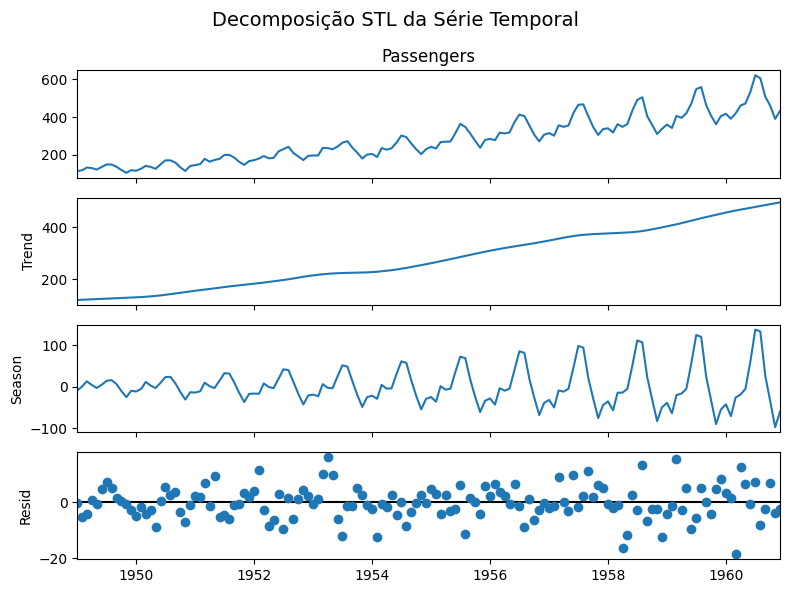

In [8]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Aplicar decomposição STL
stl = STL(df['Passengers'], seasonal=13)  # seasonal=13 é comum para séries mensais
resultado = stl.fit()

# Plotar os componentes
fig = resultado.plot()
fig.set_size_inches(8, 6)
fig.suptitle('Decomposição STL da Série Temporal', fontsize=14)
plt.tight_layout()
plt.show()

---
## Modelos Holt e Holt-Winters

Os modelos de suavização exponencial (ou alisamento exponencial) são utilizados para previsão de séries temporais. Eles fornecem uma abordagem recursiva e computacionalmente eficiente para atualização de previsões.

<br>

**Modelo de Holt (Dupla Suavização Exponencial)**

> O modelo de Holt é uma extensão do modelo de suavização exponencial simples, incluindo uma componente de tendência.

> Ele é definido pelas seguintes equações:

\begin{align}
L_t &= \alpha y_t + (1 - \alpha)(L_{t-1} + T_{t-1}) \\
T_t &= \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1} \\
\end{align}
> em que,
- $L_t$: componente de nível (ou level) estimado no tempo $t$;
- $T_t$: componente de tendência (ou crescimento) estimado no tempo $t$;
- $\alpha$: parâmetro de suavização para o nível ($0 < \alpha < 1$);
- $\beta$: parâmetro de suavização para a tendência ($0 < \beta < 1$);

> Previsões pontuais para $h$ passos a frente de $t$ são calculadas por:
$$
\widehat{y}_{t+h} = L_t + h T_t
$$

- OBS: o modelo de Holt não é adequado para séries temporais que possuem comportamento sazonal.

<br>

**Modelo de Holt-Winters (Tripla Suavização Exponencial)**

> O modelo de Holt-Winters adiciona um terceiro componente: a ***sazonalidade***, podendo ser aditiva ou multiplicativa. A versão multiplicativa é frequentemente usada quando a amplitude da sazonalidade varia com o nível da série.

> Equações para o modelo sazonal multiplicativo:

\begin{align}
L_t &= \alpha \frac{y_t}{S_{t-s}} + (1 - \alpha)(L_{t-1} + T_{t-1}) \\
T_t &= \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1} \\
S_t &= \gamma \frac{y_t}{L_t} + (1 - \gamma)S_{t-s} \\
\end{align}
> em que,
- $S_t$: componente sazonal
- $\gamma$: parâmetro de suavização da sazonalidade ($0 < \gamma < 1$)
- $s$: periodicidade da sazonalidade (por exemplo, 12 para dados mensais)

> Previsões pontuais para $h$ passos a frente de $t$ são calculadas por:
$$
\hat{y}_{t+h} = (L_t + hT_t) \cdot \widehat{S}_{t+h}
$$

- **Nota:** Para séries com sazonalidade aditiva, as fórmulas são semelhantes, mas com termos de adição em vez de multiplicação.



### Exemplo: Ajuste e Previsão

Vamos usar o modulo `ExponentialSmoothing` do `statsmodels` para:

- Ajustar a série com tendência e sazonalidade;

- Avaliar a qualidade do ajuste;

- Gerar previsões futuras.

> Para mais detalhes, veja a documentação: https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Ajustar o modelo Holt-Winters (sazonalidade multiplicativa ou aditiva)
modelo_hw = ExponentialSmoothing(df['Passengers'],
                                  trend='add',
                                  seasonal='mul', ## sazonalidade multiplicativa
                                  seasonal_periods=12).fit()

# Parâmetros ajustados e relatório do modelo
modelo_hw.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Passengers,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15952.880
Optimized:,True,AIC,709.892
Trend:,Additive,BIC,757.409
Seasonal:,Multiplicative,AICC,715.364
Seasonal Periods:,12,Date:,"Wed, 02 Jul 2025"
Box-Cox:,False,Time:,01:50:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3185898,alpha,True
smoothing_trend,1.8175e-11,beta,True


In [ ]:
# Adicionar valores ajustados ao DataFrame
df['fit_HW'] = modelo_hw.fittedvalues

print(df)

            Passengers      fit_HW
Month                             
1949-01-01         112  111.418539
1949-02-01         118  120.062000
1949-03-01         132  134.827184
1949-04-01         129  130.592576
1949-05-01         121  124.085625
...                ...         ...
1960-08-01         606  625.009023
1960-09-01         508  506.744600
1960-10-01         461  443.213024
1960-11-01         390  393.493719
1960-12-01         432  432.351048

[144 rows x 2 columns]


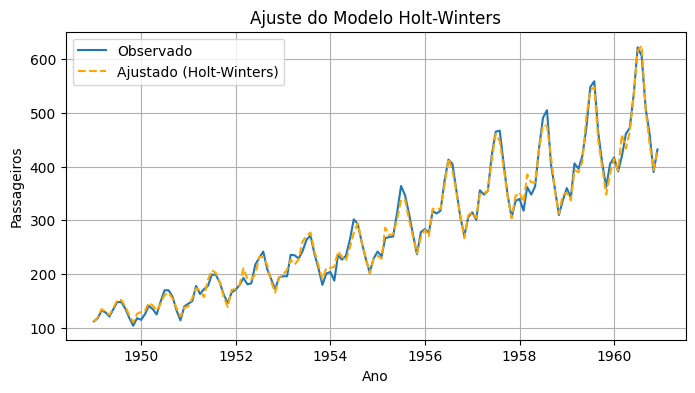

In [ ]:
# Plotar valores observados e ajustados
plt.figure(figsize=(8, 4))
plt.plot(df['Passengers'], label='Observado')
plt.plot(df['fit_HW'], label='Ajustado (Holt-Winters)', color='orange', linestyle='--')
plt.title('Ajuste do Modelo Holt-Winters')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.show()

Agora vamos utilizar o modelo ajustado para calcular previsões para essa série temporal.

> Vamos prever 24 meses a frente (2 anos).

In [ ]:
# Previsão de valores futuros
previsao_hw = modelo_hw.forecast(24)

print(previsao_hw)

1961-01-01    445.242361
1961-02-01    418.225341
1961-03-01    465.309832
1961-04-01    494.951245
1961-05-01    505.475873
1961-06-01    573.312666
1961-07-01    663.596376
1961-08-01    654.904046
1961-09-01    546.760994
1961-10-01    488.446831
1961-11-01    415.723528
1961-12-01    460.377815
1962-01-01    474.071074
1962-02-01    445.159419
1962-03-01    495.116229
1962-04-01    526.488038
1962-05-01    537.513154
1962-06-01    609.458560
1962-07-01    705.215761
1962-08-01    695.764708
1962-09-01    580.697963
1962-10-01    518.608285
1962-11-01    441.262917
1962-12-01    488.516423
Freq: MS, dtype: float64


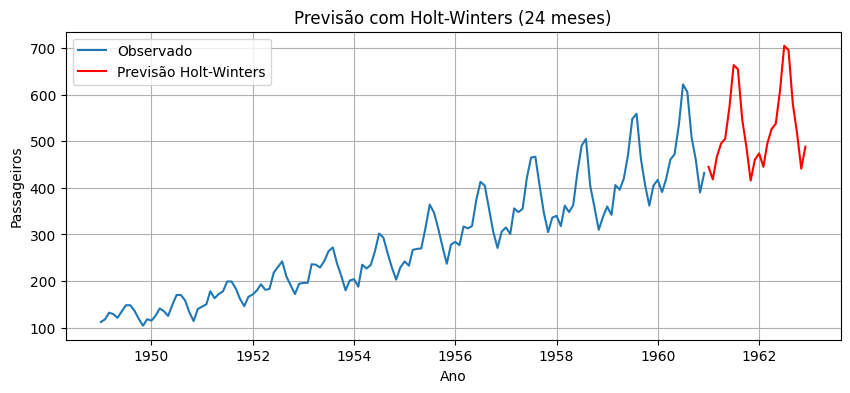

In [ ]:
# Previsão de valores futuros
previsao_hw = modelo_hw.forecast(24)

# Plotar
plt.figure(figsize=(10, 4))
plt.plot(df['Passengers'], label='Observado')
plt.plot(previsao_hw, label='Previsão Holt-Winters', color='red')
plt.title('Previsão com Holt-Winters (24 meses)')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.show()

---
## Modelos ARIMA / SARIMA

- O modelo **ARMA($p,q$)** é destinado a **séries temporais estacionárias** (a grosso modo, isso implica que a série tenha média constante, variância constante e covariância constante) e pode ser escrito pelas seguinte equação:
$$
y_t = \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}
$$
sendo $y_1, y_2, \dots$ um processo estacionário e $\phi_1, \dots, \phi_p, \theta_1, \dots, \theta_q$ o conjunto de coeficientes a serem estimados, com $\phi_p \neq 0$ e $\theta_q \neq 0$.
<br>

- Um modelo **ARMA($p,q$)** pode ser reescrito em função dos operadores de retardo ($B y_t = y_{t-1}$), resultando em:
$$
    \Phi_p(B) ~y_t = \Theta_q (B) ~\varepsilon_t
$$
em que $$\Phi_p(B) = 1 - \phi_1 B - \phi_2 B^2 - \dots - \phi_p B^p$$ é o *polinômio autoregressivo* e $$\Theta_q(B) = 1 + \theta_1 B  + \theta_2 B^2  + \dots + \theta_q B^q $$ é o *polinômio de média móvel*.
<br>


- O modelo **ARIMA$(p,d,q)$** consiste basicamente em aplicar um processo **ARMA($p,q$)** a um processo $d$-diferenças (processo de $d$-diferenciável), o qual pode ser representado pela seguinte equação:
$$
    \Phi_p(B) (1-B)^d ~y_t = \Theta_q (B) ~\varepsilon_t
$$
<br>

- Finalmente, o modelo SARIMA$(p,d,q)(P,D,Q)_s$) expande o modelo anterior para processos com comportamento sazonal, acrescento assim termos sazonais autoregressivos e de médias móveis, representado pela seguinte equação:
$$
\Phi_P(B^s) \, \phi_p(B) \, (1 - B)^d (1 - B^s)^D y_t = \Theta_Q(B^s) \, \theta_q(B) \, \varepsilon_t
$$
em que:
  - $B$ é o operador de defasagem (lag);
  - $d$ é o número de diferenciações não sazonais (integração da série);
  - $p$ e $q$ são as ordens dos termos autorregressivos e de médias móveis, respectivamente;
  - $(P,D,Q)_s$ são os análogos sazonais com periodicidade $s$ (por exemplo, $s=12$ para dados mensais com sazonalidade anual);
  - $\varepsilon_t$ representa o termo de erro, geralmente assumido como i.i.d. Normal($0, \sigma^2$).

<br>

- A seleção das ordens do modelo (valores de $p$, $d$, $q$, $P$, $D$, $Q$) é tradicionalmente feita por meio da análise da ordem de integração do processo e das estruturas de autocorrelação e autocorrelação parcial encontradas após tornar a série estacionária.
> **Esse procedimento será estudado com profundidade na disciplina de Análise de Séries Temporais.**


### Exemplo: seleção, ajuste e previsão

Com o objetivo de ilustrar o uso do modelo, podemos utilizar a biblioteca `pmdarima`, que fornece a função `auto_arima()` para seleção automática das ordens do modelo com base em critérios estatísticos (como AIC ou BIC), facilitando a aplicação do ARIMA/SARIMA.


> A biblioteca `pmdarima` não vem instalada no Google Colab e sua instalação (na versão atual) vem apresentando conflito com a versão mais atual da biblioteca `numpy`.

> A célula de código abaixo faz o downgrade da biblioteca `numpy` para a versão 1.26.4 e depois instala a biblioteca `pmdarima` na versão 2.0.4.

>> Caso apareça um erro na primeira tentativa, então reinicie a sessão e tente novamente.

In [ ]:
!pip install numpy==1.26.4 --quiet
!pip install pmdarima==2.0.4 --quiet

In [ ]:
## importa as bibliotecas e verifica as versões
import numpy as np
import pmdarima as pm
print(np.__version__, pm.__version__) # Deve exibir: 1.26.4 2.0.4

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

1.26.4 2.0.4


In [ ]:
# Ajustar modelo ARIMA automático (com sazonalidade)
modelo_auto = pm.auto_arima(
    df['Passengers'],
    seasonal=True,
    m=12  # periodicidade mensal (12 meses)
)

A célula abaixo exibe diversas informações sobre o modelo. Note que:

- Modelo é selecionado: SARIMA$(2, 1, 1)x(0, 1, 0)_{12}$;
- Parâmetros ajustados:
$\widehat{\phi_1} = 0.5960, \widehat{\phi_2} = 0.2143, \widehat{\theta_1} = -0.9819$ e $\widehat{\sigma}^2 = 129.3133$.

In [ ]:
# Exibi o resumo do modelo escolhido
print(modelo_auto.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Wed, 02 Jul 2025   AIC                           1017.847
Time:                                     01:52:00   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      

Na célula abaixo pedimos para o modelo calcular previsão para dois anos a frente (24 meses), bem como as previsões intervalares com 95\% de probabilidade de cobertura:

In [ ]:
# Gerar previsões para os próximos 24 meses
n_periods = 24
previsao, intervalo = modelo_auto.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

print("\nPrevisao Pontual:\n", previsao)

print("\nPrevisao Intervalar:\n", intervalo)


Previsao Pontual:
 1961-01-01    445.634924
1961-02-01    420.395010
1961-03-01    449.198328
1961-04-01    491.839952
1961-05-01    503.394475
1961-06-01    566.862441
1961-07-01    654.260157
1961-08-01    638.597459
1961-09-01    540.883703
1961-10-01    494.126573
1961-11-01    423.332652
1961-12-01    465.507511
1962-01-01    479.290804
1962-02-01    454.176782
1962-03-01    483.086921
1962-04-01    525.819182
1962-05-01    537.450612
1962-06-01    600.983834
1962-07-01    688.436920
1962-08-01    672.821204
1962-09-01    575.147312
1962-10-01    528.424007
1962-11-01    457.658787
1962-12-01    499.857999
Freq: MS, dtype: float64

Previsao Intervalar:
 [[423.3448346  467.92501276]
 [394.23537501 446.55464442]
 [419.83168422 478.56497202]
 [460.37622791 523.30367657]
 [470.38041866 536.40853182]
 [532.69928309 601.02559869]
 [619.22109181 689.29922222]
 [602.87979331 674.3151249 ]
 [504.6311681  577.1362384 ]
 [457.44579915 530.80734671]
 [386.30368922 460.36161495]
 [428.1911504

In [ ]:
# juntando os arquivos em um dataframe
df_previsao = pd.DataFrame({
    'Previsao': previsao,
    'IC_inferior': intervalo[:, 0],
    'IC_superior': intervalo[:, 1]
}, index=previsao.index)

print(df_previsao.head())

              Previsao  IC_inferior  IC_superior
1961-01-01  445.634924   423.344835   467.925013
1961-02-01  420.395010   394.235375   446.554644
1961-03-01  449.198328   419.831684   478.564972
1961-04-01  491.839952   460.376228   523.303677
1961-05-01  503.394475   470.380419   536.408532


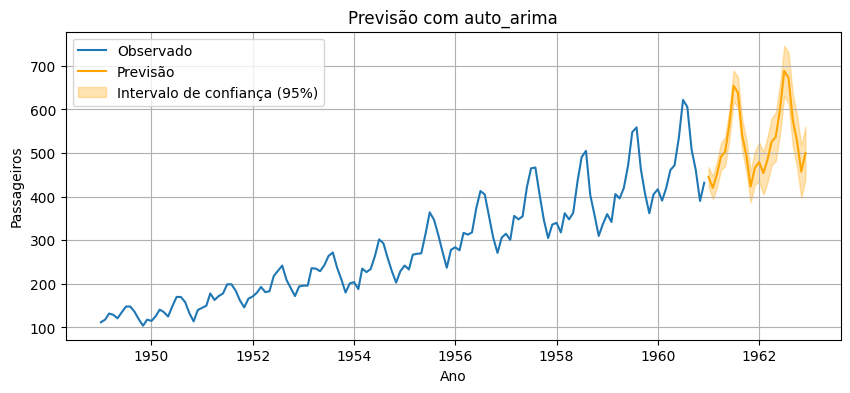

In [ ]:
## construindo o gráfico
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Passengers'], label='Observado')
plt.plot(df_previsao.index, df_previsao['Previsao'], label='Previsão', color='orange')
plt.fill_between(df_previsao.index,
                 df_previsao['IC_inferior'],
                 df_previsao['IC_superior'],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.title('Previsão com auto_arima')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.show()

---
## Modelo Prophet

O **Prophet** é uma biblioteca open-source desenvolvida pelo Facebook (Meta) para facilitar a modelagem e previsão de séries temporais. Ele é especialmente eficaz para:

- Séries com tendência e sazonalidade;
- Previsões em granularidade diária, semanal ou mensal;
- Dados com feriados, eventos especiais ou valores ausentes;
- Usuários não especialistas em modelagem estatística.


### Como funciona?

O Prophet utiliza um modelo aditivo com os seguintes componentes:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

- $g(t)$: tendência (linear ou logística, com pontos de mudança);
- $s(t)$: sazonalidade (anual, semanal, diária, etc.);
- $h(t)$: efeitos de feriados e eventos;
- $\varepsilon_t$: erro aleatório (ruído não explicado).

### Vantagens

- Interface simples baseada em `fit()` e `predict()`;
- Lida automaticamente com datas faltantes e valores ausentes;
- Suporte nativo a feriados;
- Ajuste robusto mesmo com poucos dados;
- Visualização clara dos componentes do modelo.


### Instalação

No Google Colab, instale com:

```python
!pip install prophet
```

### Exemplo: Ajuste e Previsão

In [ ]:
# Instalar Prophet (apenas necessário uma vez no Colab)
!pip install prophet --quiet

In [ ]:
# Importações
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Preparar os dados no formato esperado pelo Prophet: colunas 'ds' e 'y'
df_prophet = df["Passengers"].reset_index().rename(columns={'Month': 'ds', 'Passengers': 'y'})
print(df_prophet.head())

          ds    y
0 1949-01-01  112
1 1949-02-01  118
2 1949-03-01  132
3 1949-04-01  129
4 1949-05-01  121


In [ ]:
# Criar e ajustar o modelo
# intervalo de cobertura: 95%
modelo_prophet = Prophet(seasonality_mode='multiplicative', interval_width=0.95)  # ou 'additive' para séries sem crescimento proporcional
modelo_prophet.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsuwgi7x/t4g4wzyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsuwgi7x/jbc92ex3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99752', 'data', 'file=/tmp/tmpmsuwgi7x/t4g4wzyd.json', 'init=/tmp/tmpmsuwgi7x/jbc92ex3.json', 'output', 'file=/tmp/tmpmsuwgi7x/prophet_modelxsf1wrtz/prophet_model-20250702015206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Criar dataframe com datas futuras (previsão para os próximos 24 meses)
futuro = modelo_prophet.make_future_dataframe(periods=24, freq='MS')

print(futuro)

            ds
0   1949-01-01
1   1949-02-01
2   1949-03-01
3   1949-04-01
4   1949-05-01
..         ...
163 1962-08-01
164 1962-09-01
165 1962-10-01
166 1962-11-01
167 1962-12-01

[168 rows x 1 columns]


In [ ]:
# Realizar previsões
previsao = modelo_prophet.predict(futuro)

print(previsao)

            ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1949-01-01  113.457154   82.576134  124.643556   113.457154   113.457154   
1   1949-02-01  115.212069   80.190639  118.623415   115.212069   115.212069   
2   1949-03-01  116.797153   94.237513  135.423853   116.797153   116.797153   
3   1949-04-01  118.552067   94.747809  135.958220   118.552067   118.552067   
4   1949-05-01  120.250372   97.491148  139.588884   120.250372   120.250372   
..         ...         ...         ...         ...          ...          ...   
163 1962-08-01  562.884722  685.185404  728.917828   555.471166   571.614818   
164 1962-09-01  566.469567  577.125868  621.887595   558.431851   575.908308   
165 1962-10-01  569.938772  504.050817  547.663667   561.357527   579.901256   
166 1962-11-01  573.523617  435.194628  478.952859   564.082561   584.078261   
167 1962-12-01  576.992822  489.957387  533.374551   566.697684   588.379157   

     multiplicative_terms  multiplicati

Na figura, o gráfico é construido diretamente pela biblioteca `prophet`, no qual:
- Pontos observados (pretos): são os dados reais usados para ajustar o modelo (valores históricos).
- Previsão (linha azul clara): é o valor predito (yhat) ao longo do tempo.
- Intervalo de confiança (faixa azul): intervalo de incerteza das previsões (geralmente 80% ou 95%).

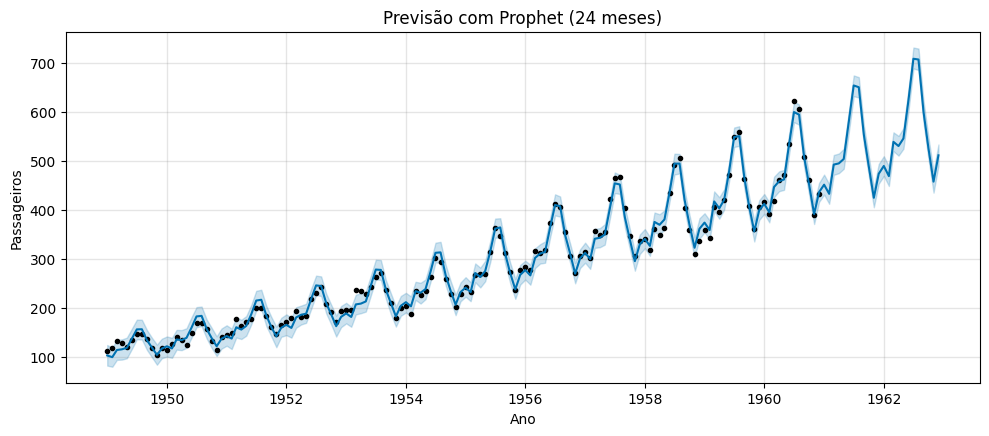

In [ ]:
# Plotar previsão
fig = modelo_prophet.plot(previsao)
fig.set_size_inches(10, 4)
plt.title('Previsão com Prophet (24 meses)')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.grid(True)
plt.show()

## Exercício 1:

Para o conjunto de dados descrito abaixo, faça o seguintes procedimentos:

1. Aplique a decomposição STL;
2. Ajuste o modelo de Holt-Winters e calcule previsão para 3 anos a frente;
3. Ajuste o modelo de SARIMA e calcule previsão para 3 anos a frente;
4. Ajuste o modelo de Prophet e calcule previsão para 3 anos a frente;

Conjunto de dados:
- **Série**: Concentração de dióxido de carbono (CO₂) na atmosfera de Mauna Loa, Havaí.
- **Fonte**: `statsmodels.datasets.co2`
- **Período**: 1958 a 2001
- **Frequência original**: Semanal (vamos converter para mensal)
- **Unidade**: Partes por milhão (ppm)

Código para acessar e tratar o conjunto de dados:
```python
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

# Carregar a série
df = co2.load_pandas().data

# Tratar dados faltantes
df = df.interpolate()

# Reamostrar para frequência mensal
df = df.resample('MS').mean()

# Visualizar
df.plot(figsize=(10, 4), title='Concentração de CO₂ em Mauna Loa (ppm)')
plt.xlabel('Ano')
plt.ylabel('ppm')
plt.grid(True)
plt.show()
```


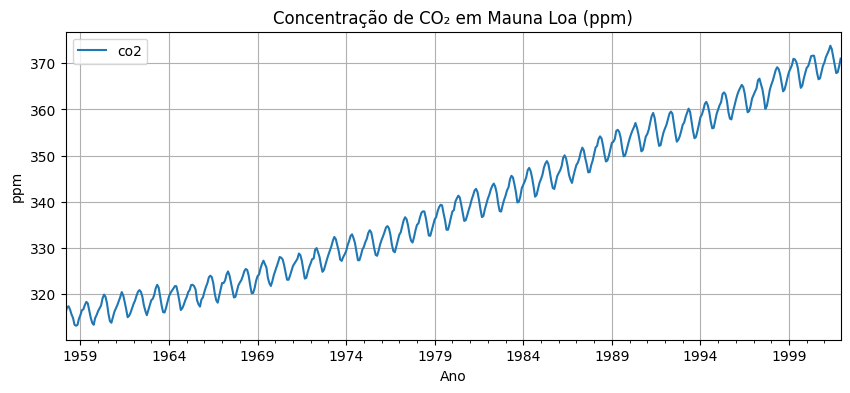

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

# Carregar a série
df = co2.load_pandas().data

# Tratar dados faltantes
df = df.interpolate()

# Reamostrar para frequência mensal
df = df.resample('MS').mean()

# Visualizar
df.plot(figsize=(10, 4), title='Concentração de CO₂ em Mauna Loa (ppm)')
plt.xlabel('Ano')
plt.ylabel('ppm')
plt.grid(True)
plt.show()

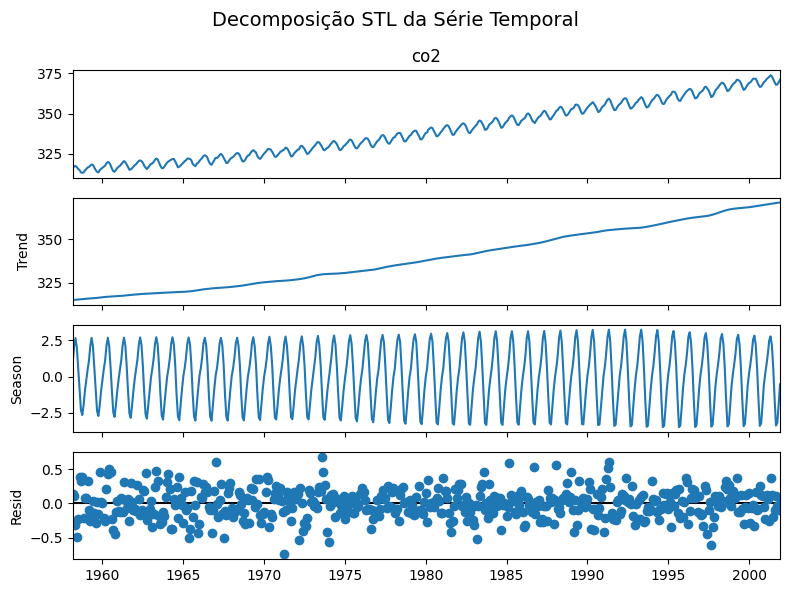

In [ ]:
# 1 - Aplique a decomposição STL

stl = STL(df['co2'], seasonal=13)
resultado = stl.fit()

fig = resultado.plot()
fig.set_size_inches(8, 6)
fig.suptitle('Decomposição STL da Série Temporal', fontsize=14)
plt.tight_layout()
plt.show()

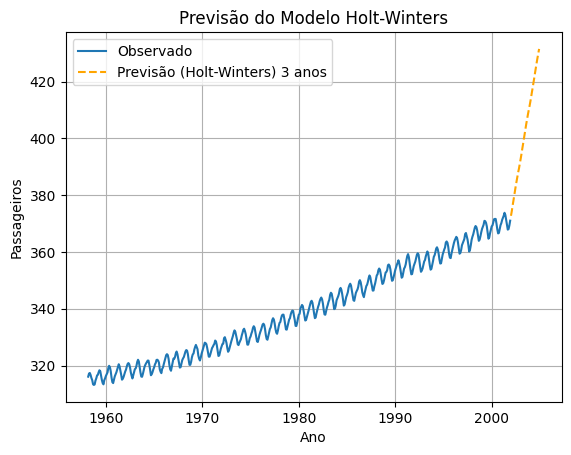

In [ ]:
# 2 - Ajuste o modelo de Holt-Winters e calcule previsão para 3 anos a frente

modelo_hw = ExponentialSmoothing(df['co2'],
                                  trend='add',
                                  seasonal='mul', ## sazonalidade multiplicativa
                                  seasonal_periods=13).fit()

# Adicionar valores ajustados ao DataFrame
previsao_hw = modelo_hw.forecast(36)

# plot

plt.plot( df.index, df['co2'], label= 'Observado')
plt.plot( previsao_hw, label= 'Previsão (Holt-Winters) 3 anos', color= 'orange', linestyle= '--')
plt.title('Previsão do Modelo Holt-Winters')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# 3 - Ajuste o modelo de SARIMA e calcule previsão para 3 anos a frente

# Ajustar modelo ARIMA automático (com sazonalidade)
modelo_auto = pm.auto_arima(
    df['co2'],
    seasonal=True,
    m=12  # periodicidade mensal (12 meses)
)

KeyboardInterrupt: 

In [ ]:
# Gerar previsões para os próximos 36 meses
n_periods = 36
previsao, intervalo = modelo_auto.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

print("\nPrevisao Pontual:\n", previsao)

print("\nPrevisao Intervalar:\n", intervalo)

In [ ]:
# juntando os arquivos em um dataframe
df_previsao = pd.DataFrame({
    'Previsao': previsao,
    'IC_inferior': intervalo[:, 0],
    'IC_superior': intervalo[:, 1]
}, index=previsao.index)

print(df_previsao.head())

In [ ]:
## construindo o gráfico
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['co2'], label='Observado')
plt.plot(df_previsao.index, df_previsao['Previsao'], label='Previsão', color='orange')
plt.fill_between(df_previsao.index,
                 df_previsao['IC_inferior'],
                 df_previsao['IC_superior'],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.title('Previsão com auto_arima')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# 4 - Ajuste o modelo de Prophet e calcule previsão para 3 anos a frente
from prophet import Prophet

# Preparar os dados no formato esperado pelo Prophet: colunas 'ds' e 'y'
df.reset_index(inplace=True)
df.rename(columns={'index': 'ds', 'co2': 'y'}, inplace=True)

df_prophet = df.copy()

In [34]:
# Criar e ajustar o modelo
# intervalo de cobertura: 95%
modelo_prophet = Prophet(seasonality_mode='multiplicative', interval_width=0.95)  # ou 'additive' para séries sem crescimento proporcional
modelo_prophet.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsuwgi7x/lfee6w9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmsuwgi7x/lke4u7xy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48263', 'data', 'file=/tmp/tmpmsuwgi7x/lfee6w9j.json', 'init=/tmp/tmpmsuwgi7x/lke4u7xy.json', 'output', 'file=/tmp/tmpmsuwgi7x/prophet_modell4s_dx70/prophet_model-20250702015434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:54:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


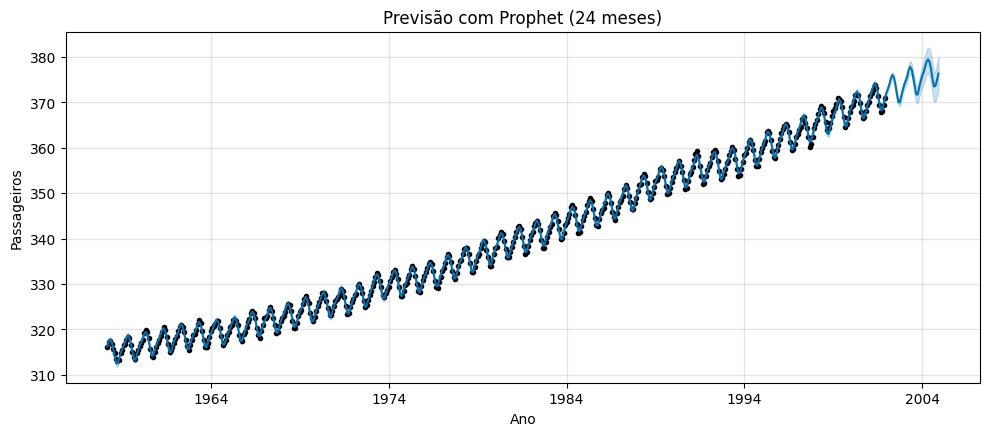

In [35]:
# Criar dataframe com datas futuras (previsão para os próximos 36 meses)
futuro = modelo_prophet.make_future_dataframe(periods=36, freq='MS')
# Realizar previsões
previsao = modelo_prophet.predict(futuro)


# Plotar previsão
fig = modelo_prophet.plot(previsao)
fig.set_size_inches(10, 4)
plt.title('Previsão com Prophet (24 meses)')
plt.xlabel('Ano')
plt.ylabel('Passageiros')
plt.grid(True)
plt.show()